In [ ]:
import os
import torch
import matplotlib.pyplot as plt
import xml.dom.minidom
from skimage.io import imread
from skimage import img_as_ubyte
from pyrr import Matrix44, Vector4, Vector3
import pyrr

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    HardPhongShader
)
from pytorch3d.renderer.cameras import look_at_view_transform

from torch_openpose.body import Body
from torch_openpose import util
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm

from tqdm import tqdm
import torch.nn as nn
import imageio
import cv2
import copy
import glob
import random

import wandb

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))
import pytorch3d
from pytorch3d_utils import (
    mitsuba_scene_to_torch_3d_no_ground, 
    where, 
    add_background_batch, 
    get_scenes_filenames,
    get_background_filenames,
    pose_loss_single_human,
    pose_loss_single_human_full_fail,
    pose_loss_detection_distance
)

In [ ]:
def get_image_and_score(
        test_mesh, 
        test_camera,
        test_opt, 
        model, 
        body_estimation, 
        renderer
    ):
    
    (canvas_orig, 
     candidate_orig,
     subset_orig,
     heatmap_avg_orig,
     paf_avg_orig) = get_body_image_from_mesh(test_mesh, body_estimation, renderer, test_camera)

    tex = torch.cat([model.texTshirt, model.texOther]).repeat(1, 1, 1)
    textures = Textures(verts_rgb=tex.cuda())    
    noise_mesh = Meshes(verts=[test_opt["verticies"]], faces=[test_opt["faces"]], textures=textures)
    
    (canvas_noise, 
     candidate_noise,
     subset_noise,
     heatmap_avg_noise,
     paf_avg_noise) = get_body_image_from_mesh(noise_mesh, body_estimation, renderer, test_camera)
    
    metric = pose_loss_single_human(subset_noise, subset_orig)
    total_fail_metric = pose_loss_single_human_full_fail(subset_noise, subset_orig)
    distance_metric = pose_loss_detection_distance(subset_noise, subset_orig, candidate_noise, candidate_orig)
    
    return canvas_orig, canvas_noise, metric, total_fail_metric, distance_metric

    
def get_body_image_from_mesh(cur_mesh, body_estimation, renderer, cameras=None):
    if cameras is None:
        images = renderer(cur_mesh)
    else:
        images = renderer(cur_mesh, cameras=cameras)
    rendering_torch_input = (images[..., :3] - 0.5).permute((0, 3, 1, 2)).float()
    
    heatmap_avg, paf_avg = body_estimation.compute_heatmap_paf_avg(rendering_torch_input, ORIG_SHAPE)
    candidate, subset = body_estimation.get_pose(heatmap_avg, paf_avg, ORIG_SHAPE)
    rendering_torch_np =  images[0, ..., :3].detach().squeeze().cpu().numpy()
    canvas = copy.deepcopy(rendering_torch_np)
    canvas = util.draw_bodypose(canvas, candidate, subset)
    
    return canvas, candidate, subset, heatmap_avg, paf_avg

def wandb_init(name):
    run = wandb.init(
        project = "mts_tshirt", 
        reinit = True,
        name = name,
        config={
            "epochs": 1,
            "learning_rate": 0.2,
            "batch_size": 8,
            "optimizer": 'ADAM'
        }
    )
    
    return run 


class Model(nn.Module):
    def __init__(self, texTshirt, texOther, renderer, body_estimation, batch_size):
        super().__init__()
        self.device = torch.device("cuda:0")
        self.renderer = renderer
        self.texOther = texOther
        self.body_estimation = body_estimation
        self.cur_meshes = None
        self.batch_size = batch_size
        
        self.texTshirt = nn.Parameter(
            torch.zeros_like(texTshirt).to(self.device)
        )
        
        ## loss functions
        self.objective = torch.nn.MSELoss()
        self.zero_heatmap = torch.zeros((self.batch_size, 19, 64, 64), device=self.device)
        self.zero_paf = torch.zeros((self.batch_size, 38, 64, 64), device=self.device)
        
        # lighting info
        self.ambient_color = torch.tensor([[0.5, 0.5, 0.5]]).repeat(self.batch_size, 1)
        self.diffuse_color = torch.tensor([[0.3, 0.3, 0.3]]).repeat(self.batch_size, 1)
        self.specular_color = torch.tensor([[0.2, 0.2, 0.2]]).repeat(self.batch_size, 1)
        
    def forward(self, verts, faces, R, T):
        tex = torch.cat([self.texTshirt, self.texOther]).repeat(self.batch_size, 1, 1)
        textures = Textures(verts_rgb=tex.cuda())
        
        self.cur_meshes = Meshes(verts=verts, faces=faces, textures=textures)
        
        cameras = OpenGLPerspectiveCameras(
            znear=0.1,
            zfar=1000,
            fov=15,
            degrees=True,
            device=device, 
            R=R, 
            T=T
        )
        
        mesh_centers = torch.mean(verts, 1)
        cam_centers = cameras.get_camera_center()

        direction = cam_centers - mesh_centers
        
        
        lights = DirectionalLights(
            device=device, 
            direction=direction,
            ambient_color=self.ambient_color,
            diffuse_color=self.diffuse_color,
            specular_color=self.specular_color
        )
        images = self.renderer(self.cur_meshes, cameras=cameras, lights=lights)
        
        #
        body_input = (images[..., :3] - 0.5).permute((0, 3, 1, 2)).float()
        paf, heat = self.body_estimation.model(body_input)
        
        ob_val_heat = self.objective(heat, self.zero_heatmap)
        ob_val_paf = self.objective(paf, self.zero_paf)
        
        # Calculate the silhouette loss
        loss = ob_val_heat + ob_val_paf
        return loss, images

In [ ]:
ORIG_SHAPE = (512, 512, 3)
DATA_ROOT = 'data/radek'
# Setup
device = torch.device("cuda:0")
torch.cuda.set_device(device)

# Set paths
DATA_SET_NAME = 'tshirt_torch'
snapshot_name = f'../snapshots/torch3d_tshirt_{DATA_SET_NAME}.npy'
train_dir = f'../data/{DATA_SET_NAME}/train'
test_dir = f'../data/{DATA_SET_NAME}/test'

train_scenes = get_scenes_filenames(train_dir)
test_scenes = get_scenes_filenames(test_dir)
print(len(train_scenes))
print(len(test_scenes))

master_scene = 'data/radek/00008_mesh88_animated.xml'
mesh, cameras, optmization_input = mitsuba_scene_to_torch_3d_no_ground(master_scene, DATA_ROOT)

In [ ]:
raster_settings = RasterizationSettings(image_size=512, blur_radius=0.0, faces_per_pixel=1)
lights = PointLights(device=device, location=[[0.0, 0.0, 3.0]])

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ), 
    shader=HardPhongShader(
        device=device, 
        cameras=cameras, 
        lights=lights
    )
)


Text(0.5, 1.0, 'Pytorch3d')

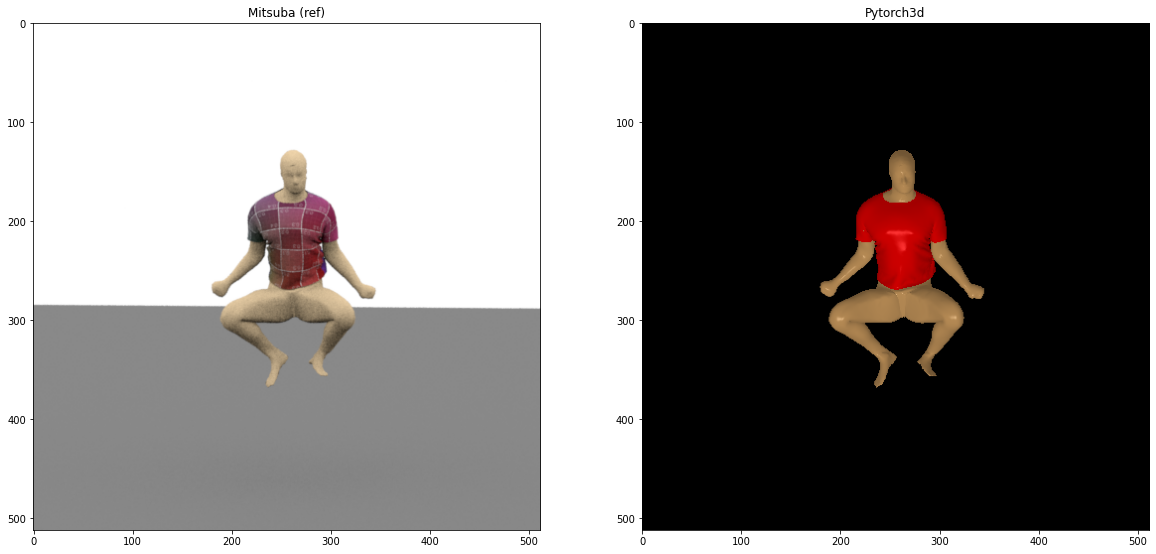

In [5]:
image = renderer(mesh)   # (1, H, W, 4)
ref_image = cv2.imread('data/radek/out.png')
ref_image = cv2.cvtColor(ref_image, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(ref_image)

ax.set_title("Mitsuba (ref)")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(image.squeeze().cpu().numpy())
ax.set_title("Pytorch3d")

In [6]:
run = wandb_init('torch3d directional light')
steps = len(train_scenes) // run.config.batch_size

ORIG_SHAPE = (512, 512, 3)

body_estimation = Body('/home/ax/data/programs/pytorch-openpose/model/body_pose_model.pth', True)

# set defaults
body_estimation.imageToTest_padded_shape = ORIG_SHAPE
body_estimation.pad = [0, 0, 0, 0]

# Initialize a model using the renderer, mesh and reference image
model = Model(
    texTshirt=optmization_input["texTshirt"], 
    texOther=optmization_input["texOther"], 
    renderer=renderer,
    body_estimation=body_estimation,
    batch_size=run.config.batch_size
).to(device)

# Create an optimizer. Here we are using Adam and we pass in the parameters of the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)


In [7]:
global_step = 0
for epoch in range(run.config.epochs):
    print(f"run {epoch + 1}/{run.config.epochs}")
    for step in tqdm(range(steps)):
        optimizer.zero_grad()
        
        batch_verts = []
        batch_faces = []
        batch_R = []
        batch_T = []
        
        for i in range(step * run.config.batch_size, (step * run.config.batch_size) + run.config.batch_size):
            _, _, opt_input = mitsuba_scene_to_torch_3d_no_ground(train_scenes[i], train_dir)
            batch_verts.append(opt_input["verticies"])
            batch_faces.append(opt_input["faces"])
            batch_R.append(opt_input["R"])
            batch_T.append(opt_input["T"])
        
        loss, cur_image = model(
            torch.stack(batch_verts), 
            torch.stack(batch_faces), 
            torch.stack(batch_R), 
            torch.stack(batch_T), 
        )
        
        loss.backward()
        optimizer.step()
        wandb.log({'loss': loss.item()}, step=global_step)
        global_step += 1
        
final_texture = model.texTshirt.detach().cpu().numpy()
np.save(snapshot_name, final_texture)

  0%|          | 0/225 [00:00<?, ?it/s]

run 1/1


100%|██████████| 225/225 [15:30<00:00,  4.13s/it]


In [8]:
canvas_orig_list = []
canvas_noise_list = []
metric_list = []
total_fail_metric_list = []
distance_metric_list = []
i = 0
for test_scene in tqdm(test_scenes):
    test_mesh, test_camera, test_opt = mitsuba_scene_to_torch_3d_no_ground(test_scene, test_dir)
    
    canvas_orig, canvas_noise, metric, total_fail_metric, distance_metric = get_image_and_score(
        test_mesh, 
        test_camera,
        test_opt,
        model, 
        body_estimation, 
        renderer
    )
    canvas_orig_list.append(canvas_orig)
    canvas_noise_list.append(canvas_noise)
    metric_list.append(metric)
    total_fail_metric_list.append(total_fail_metric)
    distance_metric_list.append(distance_metric)
    i += 1
#     if i > 9:
#         break

# filter where person was detected before altering
canvas_orig_list_filtered, canvas_noise_list_filtered, metric_list_filtered, total_fail_metric_list_filtered, distance_metric_list_filtered = zip(*(
    (canvas_orig, canvas_noise, metric, total_fail_metric, distance_metric) for canvas_orig, canvas_noise, metric, total_fail_metric, distance_metric in zip(canvas_orig_list, canvas_noise_list, metric_list, total_fail_metric_list, distance_metric_list) if metric >= 0)
)
print(f"Avg metric: {np.mean(metric_list_filtered)} of {len(metric_list_filtered)} test samples")
print(f"Total fail Avg metric: {np.mean(total_fail_metric_list_filtered)} of {len(total_fail_metric_list_filtered)} test samples")
print(f"Distance Avg metric: {np.mean(distance_metric_list_filtered)} of {len(total_fail_metric_list_filtered)} test samples")


wandb.log({'avgMetric': np.mean(metric_list_filtered)})
wandb.log({'Total fail Avg metric': np.mean(total_fail_metric_list_filtered)})
wandb.log({'Distance Avg metric': np.mean(distance_metric_list_filtered)})

100%|██████████| 200/200 [04:22<00:00,  1.31s/it]


Avg metric: 0.3858667204255439 of 99 test samples
Total fail Avg metric: 0.5454545454545454 of 99 test samples
Distance Avg metric: 0.0954413415197729 of 99 test samples


Error generating diff: Command '['git', 'diff', '--submodule=diff', '55863cc0c44c4cef5f7d6efd3922044c7c2bf7e1']' timed out after 5 seconds


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

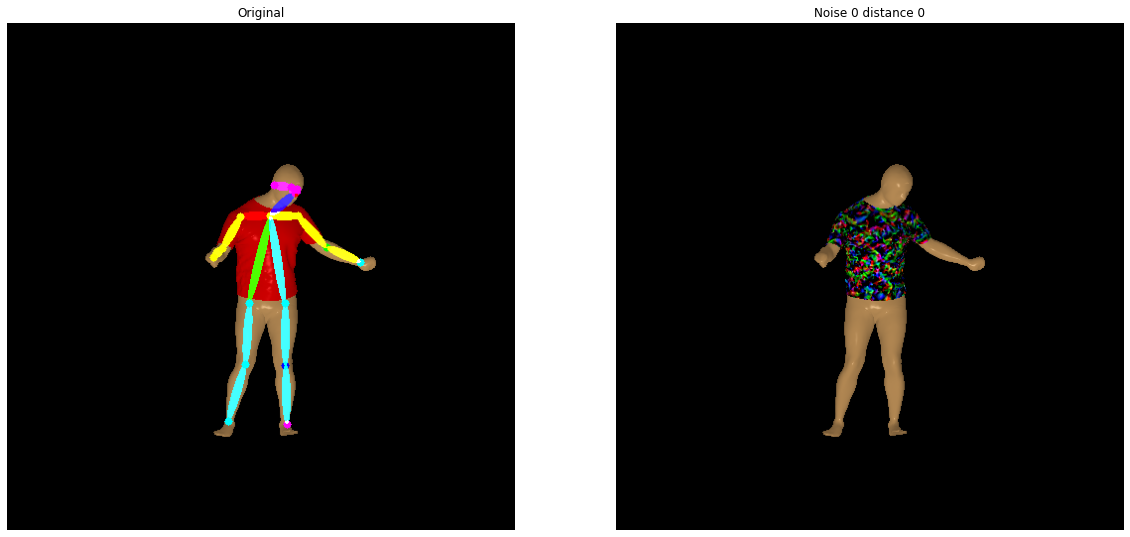

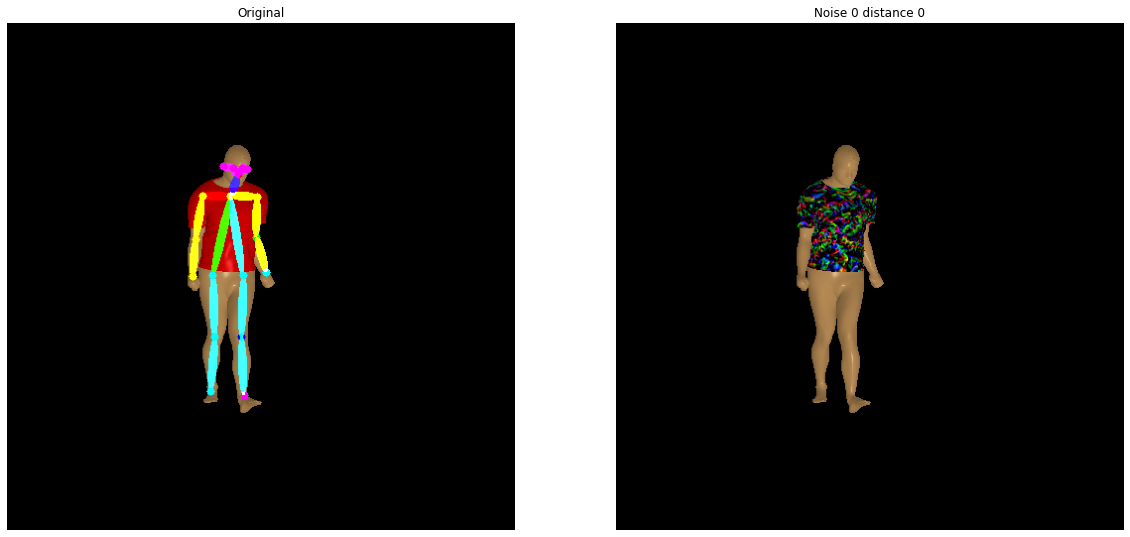

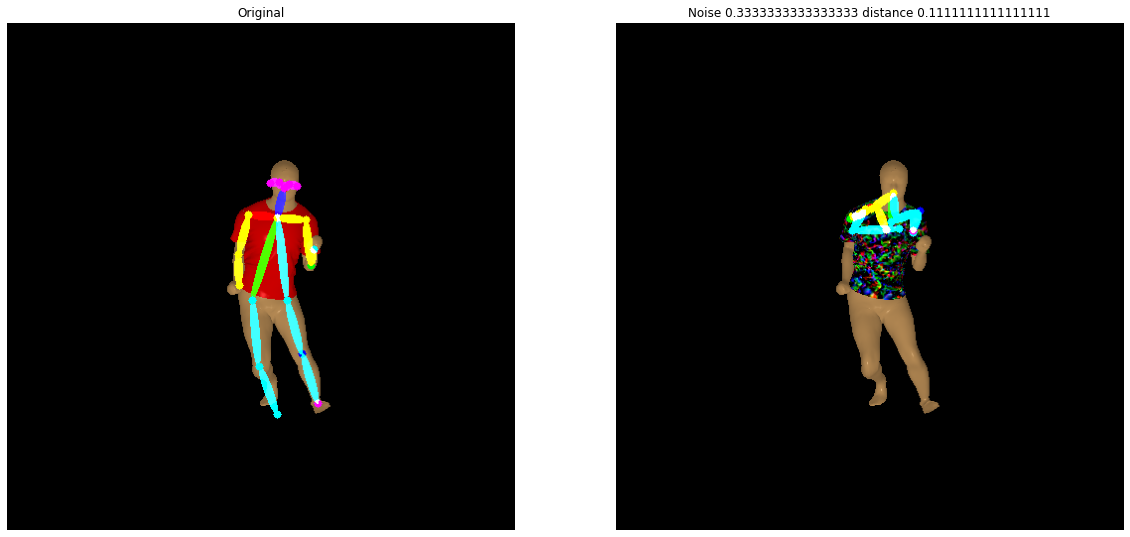

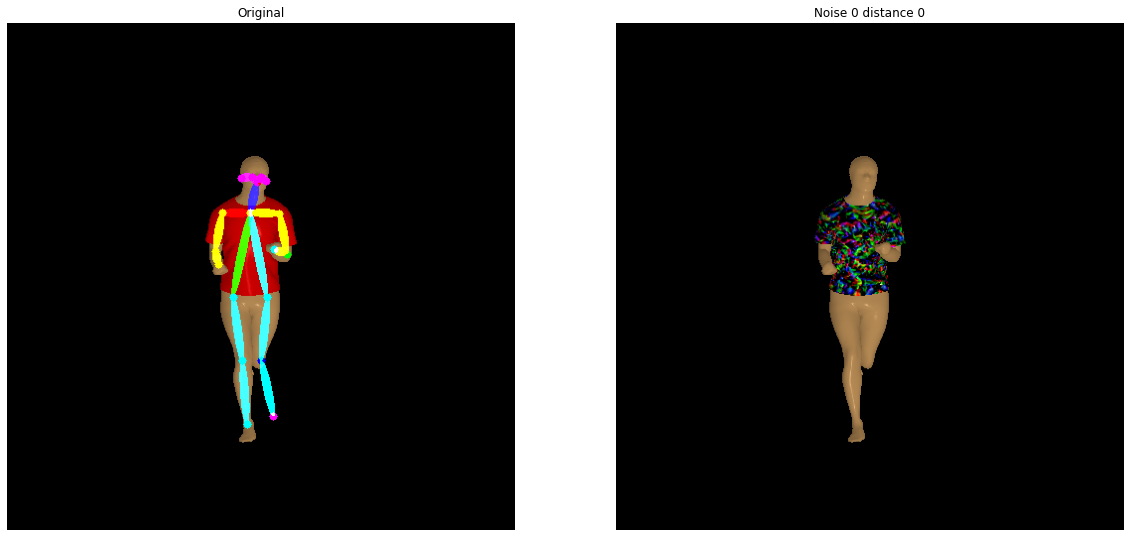

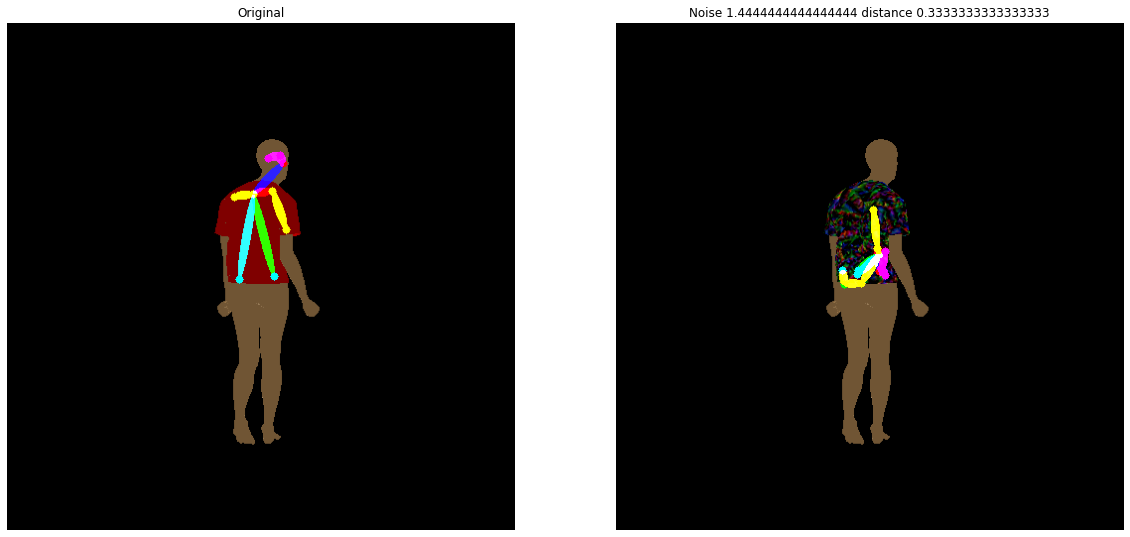

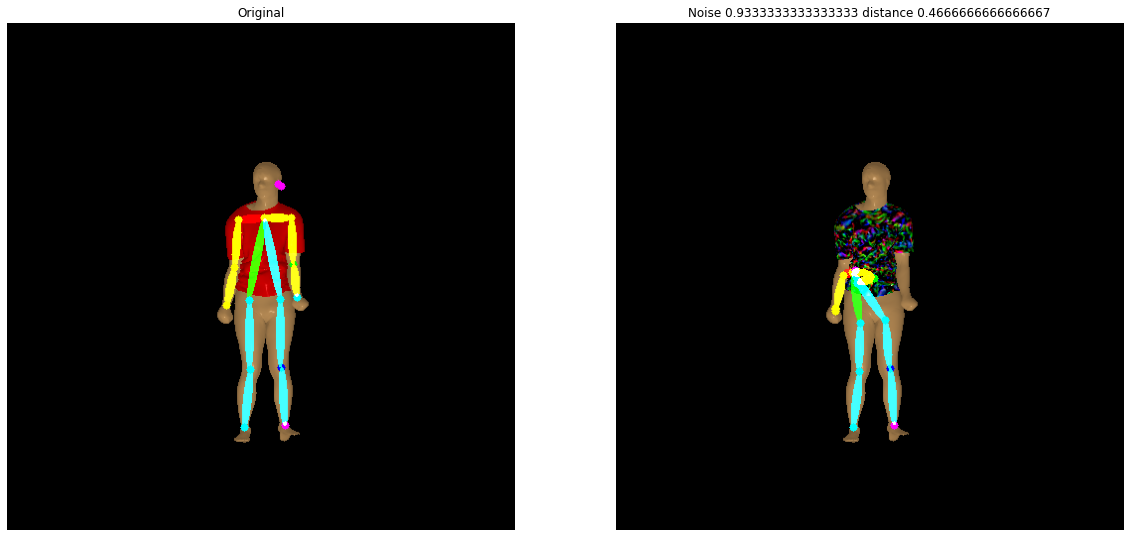

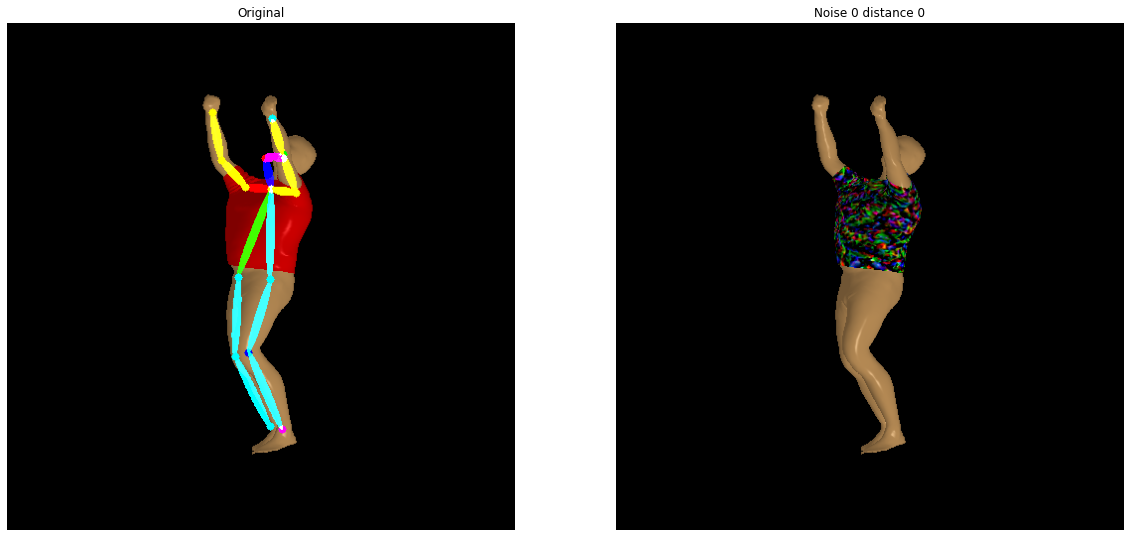

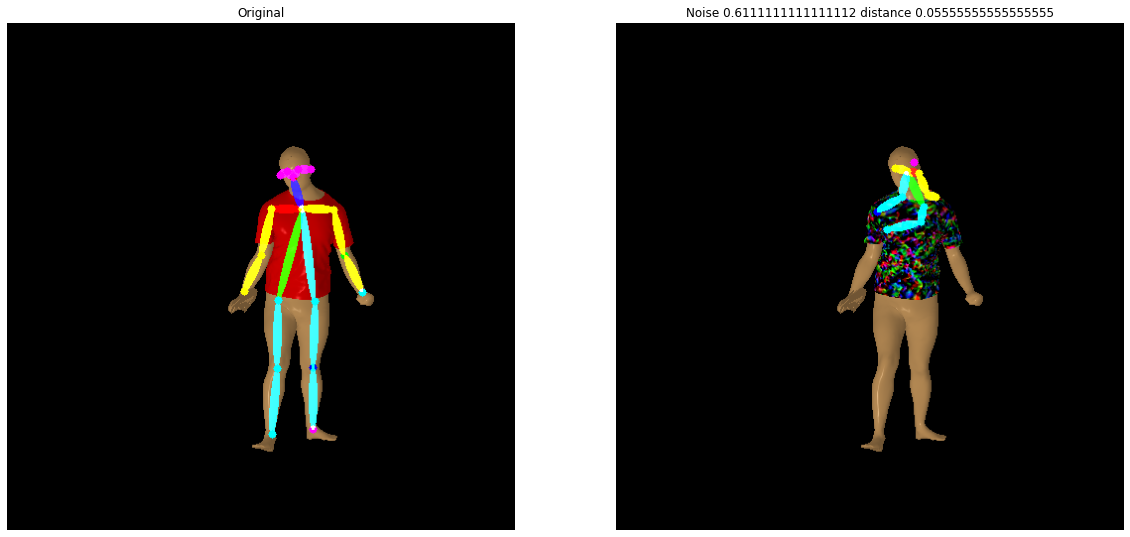

In [10]:
plot_cnt = 8
figures = []
for i in range(plot_cnt):
    fig = plt.figure(figsize=(20, 80))
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(canvas_orig_list_filtered[i])
    ax.axis('off')
    ax.set_title('Original')

    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(canvas_noise_list_filtered[i])
    ax.axis('off')
    ax.set_title(f'Noise {metric_list_filtered[i]} distance {distance_metric_list_filtered[i]}')